# Redes Neurais
## Prática I - Classificação de padrões

## Base de dados: Breast Cancer

#### Aluno: Giovani Ferreira Machado

In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from matplotlib import pyplot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
tf.random.set_seed(1234)

In [4]:
def piecewise_norm(vec,val,n):
    assert val > min(vec)
    
    return np.where(vec < val, n*(vec - min(vec))/(val - min(vec)), (1-n)*(vec - val)/(max(vec) - val) + n)

In [5]:
def transform_data(dataset,dataset_columns,normalize=True):
    new_df = pd.DataFrame()
    for name in dataset.columns:
        if name in dataset_columns.keys():
            
            if dataset_columns[name] == 'categorical':
                raw_data = dataset[name].values
                d_encoder = LabelEncoder()
                d_encoder.fit(raw_data)
                d_encoded = d_encoder.transform(raw_data)
                dummy_y = to_categorical(d_encoded)
                #print(dummy_y.shape)
                
                for (j,k) in enumerate(d_encoder.classes_):
                    new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
            
            
            elif dataset_columns[name] == 'numeric':
                raw_data = dataset[name].values
                if normalize:
                    new_df[name] = (raw_data - min(raw_data))/(max(raw_data) - min(raw_data))
                else:
                    new_df[name] = raw_data
                
            elif dataset_columns[name] == 'original':
                new_df[name] = dataset[name].values
            
            elif dataset_columns[name] == 'target':
                new_df[name] = dataset[name].values
                
    return new_df

In [6]:
def create_model(hidden_neurons = [4], hidden_activation = ['relu'], output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='relu'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='relu'))
        

    model.add(Dense(n_output, activation=output_activation))
    # Compile model
    opt = Adam(lr=lr)
    #model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [7]:
# # forma 1 de definir a função para plotar as curvas de aprendizado
# def plot_training(train_metric='loss', val_metric='val_loss'):
#     # plot training history    
#     try:
#         pyplot.plot(history.history[train_metric], label='train')
#         pyplot.plot(history.history[val_metric], label='validation')
#         pyplot.legend()
#         pyplot.show()
        
#     except KeyError:
#         pyplot.plot(history.history[train_metric], label='train')
#         pyplot.legend()
#         pyplot.show()

In [8]:
def plot_training(train_metric='loss', val_metric='val_loss'):
    # plot training history
    print('loss x epochs')

    pyplot.plot(history.history[train_metric], label='train')
        
    #Dealing with KeyError: there is no validation set for some examples
    validation_history = history.history.get('val_loss')
    if history.history.get('val_loss'):
        pyplot.plot(validation_history, label='validation')
    
    pyplot.legend()
    pyplot.show()

In [9]:
def print_metrics(x_test, y_test):
    raw_Y_pred = model.predict(x_test)
    y_pred = np.where(raw_Y_pred > 0.5, 1, 0)
    print('Confusion Matrix')
    print(confusion_matrix(y_test, y_pred))
    print()
    print()
    print('Classification Report')
    target_names = ['0','1']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print()
    print('Normalized confusion matrix')
    print_confusion_matrix(x_test, y_test)

In [10]:
def print_confusion_matrix(x_test, y_test):
    plt.rc('figure', figsize=(10, 5))
    raw_Y_pred = model.predict(x_test)
    y_pred = np.where(raw_Y_pred > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmn,annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [11]:
# from IPython.display import display, HTML

# CSS = """
# .output {
#     align-items: center;
# }
# """

# HTML('<style>{}</style>'.format(CSS))

In [12]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

# Preparação dos dados

In [13]:
with open('data_info.json','r') as f:
    dataset_columns = json.load(f)

In [14]:
dataset_columns

{'ID': 'categorical',
 'radius': 'numeric',
 'texture': 'numeric',
 'perimeter': 'numeric',
 'area': 'numeric',
 'smoothness': 'numeric',
 'compacity': 'numeric',
 'concavity': 'numeric',
 'pts_concavity': 'numeric',
 'symmetry': 'numeric',
 'fractal': 'numeric',
 'std_radius': 'numeric',
 'std_texture': 'numeric',
 'std_perimeter': 'numeric',
 'std_area': 'numeric',
 'std_smoothness': 'numeric',
 'std_compacity': 'numeric',
 'std_concavity': 'numeric',
 'std_pts_concavity': 'numeric',
 'std_symmetry': 'numeric',
 'std_fractal': 'numeric',
 'minor_radius': 'numeric',
 'minor_texture': 'numeric',
 'minor_perimeter': 'numeric',
 'minor_area': 'numeric',
 'minor_smoothness': 'numeric',
 'minor_compacity': 'numeric',
 'minor_concavity': 'numeric',
 'minor_pts_concavity': 'numeric',
 'minor_symmetry': 'numeric',
 'minor_fractal': 'numeric',
 'target': 'target'}

In [15]:
dataset = pd.read_csv('class_breast.csv')

## Parte I - Compreensão do problema e análise de variáveis



### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

In [16]:
dataset

,ID,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,...,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal,target
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,M
565,926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,M
566,926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,M
567,927241,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,M


In [17]:
target = dataset['target'].values

In [18]:
np.unique(target, return_counts=True)

(array(['B', 'M'], dtype=object), array([357, 212], dtype=int64))

#### Resposta

In [19]:
dataset.head().T

,0,1,2,3,4
ID,842302,842517,84300903,84348301,84358402
radius,17.99,20.57,19.69,11.42,20.29
texture,10.38,17.77,21.25,20.38,14.34
perimeter,122.8,132.9,130,77.58,135.1
area,1001,1326,1203,386.1,1297
smoothness,0.1184,0.08474,0.1096,0.1425,0.1003
compacity,0.2776,0.07864,0.1599,0.2839,0.1328
concavity,0.3001,0.0869,0.1974,0.2414,0.198
pts_concavity,0.1471,0.07017,0.1279,0.1052,0.1043
symmetry,0.2419,0.1812,0.2069,0.2597,0.1809


<font color='red'>
O "atributo" ID é apenas um controle dos registros, o mesmo não traz informação para apoiar a solução do problema e ainda poderia prejudicar o treinamento da rede. Abaixo o mesmo será retirado da base.
</font>

In [20]:
dataset.drop(labels=['ID'],axis=1,inplace=True)

### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

In [21]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compacity,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
pts_concavity,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


#### Resposta

<font color='red'>
Uma das formas de selecionar variáveis é através da verificação da correlação entre as mesmas. A motivação de utilizar a correlação é que a mesma indica atributos que trazem a mesma informação para o problema, então atributos fortemente correlacionados poderiam ser retirados do problema. A visualização de uma matriz de correlação é uma boa forma de iniciar a análise:
</font>

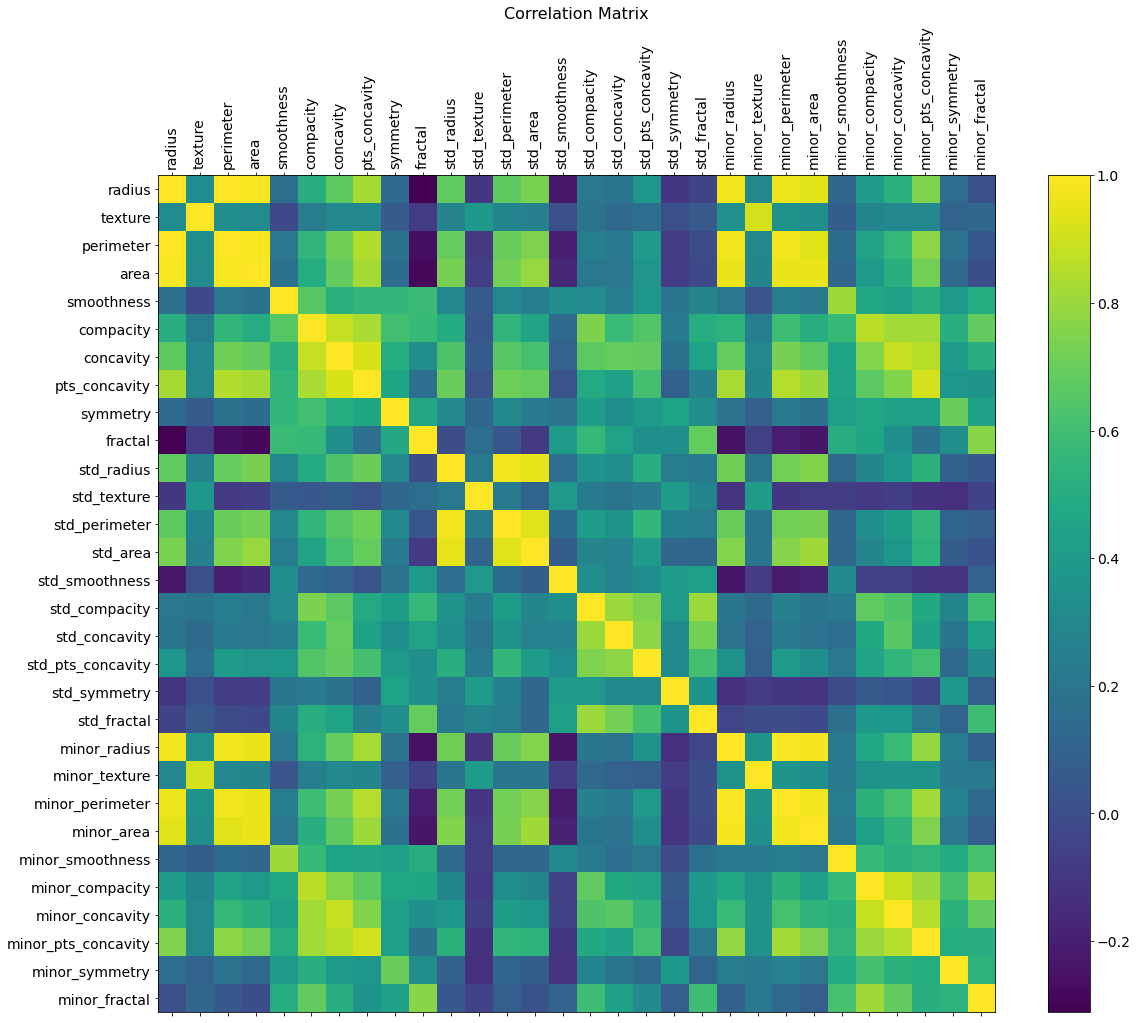

In [22]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Através da matriz de correlação é possível verificar a correlação entre as features (ou atributos). Observando a figura acima podemos separar grupos com atributos correlacionados, alguns exemplos: 
- radius, perimeter, area;
- compacity, concavity, pts_concavity
- std_radius, std_perimeter, std_area;
- std_compacity, std_concavity, std_pts_concavity
- minor_radius, minor_perimeter, minor_area;
- minor_compacity, minor_concavity, minor_pts_concavity;

O código abaixo exibe a matriz de correlação em um dataframe:

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(dataset.corr(method='pearson', min_periods=1))

,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,fractal,std_radius,std_texture,std_perimeter,std_area,std_smoothness,std_compacity,std_concavity,std_pts_concavity,std_symmetry,std_fractal,minor_radius,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal
radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compacity,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
pts_concavity,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


Abaixo será feita uma busca em atributos com correlação acima de 0,90. É razoável avaliar se a retirada destes atributos não trará queda no desempenho dos modelos:

In [24]:
# Create correlation matrix
corr_matrix = dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

to_drop

['perimeter',
 'area',
 'pts_concavity',
 'std_perimeter',
 'std_area',
 'minor_radius',
 'minor_texture',
 'minor_perimeter',
 'minor_area',
 'minor_pts_concavity']

"Plotando" estes atributos é possível visualizar relações entre grupos conforme descrito acima.

In [25]:
#sns.pairplot(dataset[['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compacity','concavity', 'pts_concavity', 'symmetry', 'fractal','target']], hue="target", diag_kind="hist")
#sns.pairplot(dataset[['radius', 'texture', 'perimeter', 'area', 'target']], hue="target", diag_kind="hist")
# sns.pairplot(dataset[['radius', 
#                       'perimeter',
#                       'area',
#                       'concavity',
#                       'pts_concavity',
#                       'std_radius',
#                       'std_perimeter',
#                       'std_area',
#                       'minor_radius',
#                       'minor_texture',
#                       'minor_perimeter',
#                       'minor_area',
#                       'minor_pts_concavity',
#                       'target']], 
#              hue="target", diag_kind="hist")

In [26]:
dataset_reduzido = dataset.drop(to_drop, axis=1)
dataset_reduzido

,radius,texture,smoothness,compacity,concavity,symmetry,fractal,std_radius,std_texture,std_smoothness,...,std_concavity,std_pts_concavity,std_symmetry,std_fractal,minor_smoothness,minor_compacity,minor_concavity,minor_symmetry,minor_fractal,target
0,17.99,10.38,0.11840,0.27760,0.30010,0.2419,0.07871,1.0950,0.9053,0.006399,...,0.05373,0.01587,0.03003,0.006193,0.16220,0.66560,0.7119,0.4601,0.11890,M
1,20.57,17.77,0.08474,0.07864,0.08690,0.1812,0.05667,0.5435,0.7339,0.005225,...,0.01860,0.01340,0.01389,0.003532,0.12380,0.18660,0.2416,0.2750,0.08902,M
2,19.69,21.25,0.10960,0.15990,0.19740,0.2069,0.05999,0.7456,0.7869,0.006150,...,0.03832,0.02058,0.02250,0.004571,0.14440,0.42450,0.4504,0.3613,0.08758,M
3,11.42,20.38,0.14250,0.28390,0.24140,0.2597,0.09744,0.4956,1.1560,0.009110,...,0.05661,0.01867,0.05963,0.009208,0.20980,0.86630,0.6869,0.6638,0.17300,M
4,20.29,14.34,0.10030,0.13280,0.19800,0.1809,0.05883,0.7572,0.7813,0.011490,...,0.05688,0.01885,0.01756,0.005115,0.13740,0.20500,0.4000,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,0.11100,0.11590,0.24390,0.1726,0.05623,1.1760,1.2560,0.010300,...,0.05198,0.02454,0.01114,0.004239,0.14100,0.21130,0.4107,0.2060,0.07115,M
565,20.13,28.25,0.09780,0.10340,0.14400,0.1752,0.05533,0.7655,2.4630,0.005769,...,0.03950,0.01678,0.01898,0.002498,0.11660,0.19220,0.3215,0.2572,0.06637,M
566,16.60,28.08,0.08455,0.10230,0.09251,0.1590,0.05648,0.4564,1.0750,0.005903,...,0.04730,0.01557,0.01318,0.003892,0.11390,0.30940,0.3403,0.2218,0.07820,M
567,20.60,29.33,0.11780,0.27700,0.35140,0.2397,0.07016,0.7260,1.5950,0.006522,...,0.07117,0.01664,0.02324,0.006185,0.16500,0.86810,0.9387,0.4087,0.12400,M


## 2.	Treinamento do modelo de Rede Neural

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

In [27]:
#Parâmetros do modelo 

hidden_neurons = [15]
activation_layers = ['relu']

output_activation = 'sigmoid'

lr = 0.05
epochs = 50

In [28]:
dataset

,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,fractal,...,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,M
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,M
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,M
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,M


In [29]:
new_df = transform_data(dataset,dataset_columns,normalize=False)
new_df.head()

,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,fractal,...,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [30]:
new_df_reduzido = new_df.drop(to_drop, axis=1)
new_df_reduzido

,radius,texture,smoothness,compacity,concavity,symmetry,fractal,std_radius,std_texture,std_smoothness,...,std_concavity,std_pts_concavity,std_symmetry,std_fractal,minor_smoothness,minor_compacity,minor_concavity,minor_symmetry,minor_fractal,target
0,17.99,10.38,0.11840,0.27760,0.30010,0.2419,0.07871,1.0950,0.9053,0.006399,...,0.05373,0.01587,0.03003,0.006193,0.16220,0.66560,0.7119,0.4601,0.11890,M
1,20.57,17.77,0.08474,0.07864,0.08690,0.1812,0.05667,0.5435,0.7339,0.005225,...,0.01860,0.01340,0.01389,0.003532,0.12380,0.18660,0.2416,0.2750,0.08902,M
2,19.69,21.25,0.10960,0.15990,0.19740,0.2069,0.05999,0.7456,0.7869,0.006150,...,0.03832,0.02058,0.02250,0.004571,0.14440,0.42450,0.4504,0.3613,0.08758,M
3,11.42,20.38,0.14250,0.28390,0.24140,0.2597,0.09744,0.4956,1.1560,0.009110,...,0.05661,0.01867,0.05963,0.009208,0.20980,0.86630,0.6869,0.6638,0.17300,M
4,20.29,14.34,0.10030,0.13280,0.19800,0.1809,0.05883,0.7572,0.7813,0.011490,...,0.05688,0.01885,0.01756,0.005115,0.13740,0.20500,0.4000,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,0.11100,0.11590,0.24390,0.1726,0.05623,1.1760,1.2560,0.010300,...,0.05198,0.02454,0.01114,0.004239,0.14100,0.21130,0.4107,0.2060,0.07115,M
565,20.13,28.25,0.09780,0.10340,0.14400,0.1752,0.05533,0.7655,2.4630,0.005769,...,0.03950,0.01678,0.01898,0.002498,0.11660,0.19220,0.3215,0.2572,0.06637,M
566,16.60,28.08,0.08455,0.10230,0.09251,0.1590,0.05648,0.4564,1.0750,0.005903,...,0.04730,0.01557,0.01318,0.003892,0.11390,0.30940,0.3403,0.2218,0.07820,M
567,20.60,29.33,0.11780,0.27700,0.35140,0.2397,0.07016,0.7260,1.5950,0.006522,...,0.07117,0.01664,0.02324,0.006185,0.16500,0.86810,0.9387,0.4087,0.12400,M


In [31]:
#X = new_df.values[:,:-1].astype('float')
# Utilizando a base sem os features de alta correlação
X = new_df.drop(to_drop, axis=1).values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
Y = encoder.fit_transform(target)

n_input = X.shape[1]
n_output = 1

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [33]:
#y_test

In [34]:
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                315       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


#### Resposta

In [36]:
#callback = EarlyStopping(monitor='loss', patience=5)

es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.00, callbacks =[es, mc], verbose=0)


#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 00025: early stopping
Train: 0.925, Test: 0.956


loss x epochs


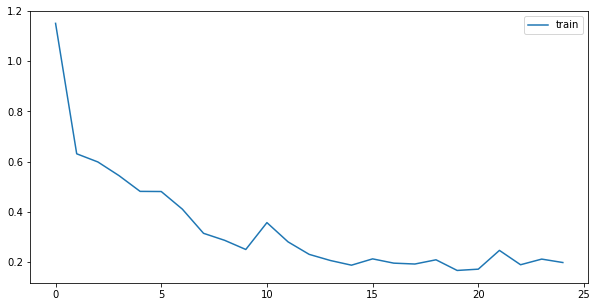

In [37]:
plt.rc('figure', figsize=(10, 5))
plot_training(train_metric='loss', val_metric='val_loss')

Confusion Matrix
[[71  0]
 [ 5 38]]


Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        71
           1       1.00      0.88      0.94        43

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114


Normalized confusion matrix


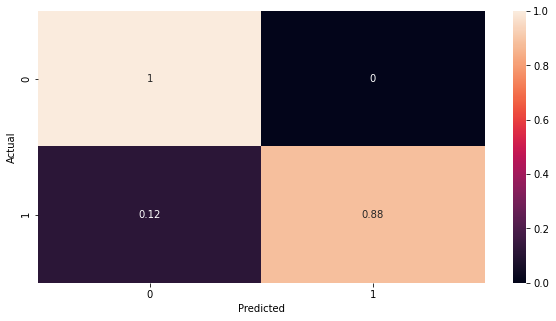

In [38]:
print_metrics(x_test, y_test)

<font color='red'>
    Mesmo sem realizar a normalização dos dados o modelo apresentou um resultado razoável. A acurácia foi de 0,96, f1-score das duas classes acima 0,94, não indicando nenhum falso positivo. <br>
    Fazendo uma análise prática da possível utilização do modelo (apoio para diagnóstico de câncer), entendo que devemos buscar minimizar o número de falso negativos. Visto que é melhor o modelo indicar um câncer malígno (não sendo), fazendo com que o especialista investigue com maior cuidado do que o contrário.  
</font>

### 2)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [39]:
new_df = transform_data(dataset,dataset_columns,normalize=True)
new_df.head()

,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,fractal,...,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,M
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,M
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,M
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,M
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,M


In [40]:
del model 

In [41]:
#X = new_df.values[:,:-1].astype('float')
# Utilizando a base sem os features de alta correlação
X = new_df.drop(to_drop, axis=1).values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
Y = encoder.fit_transform(target)

n_input = X.shape[1]
n_output = 1

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


#### Resposta

In [43]:
# #callback = EarlyStopping(monitor='loss', patience=5)
# history = model.fit(x=x_train,y=y_train,epochs=epochs,validation_split=0, verbose=0)

es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0, callbacks =[es, mc], verbose=0)

Epoch 00015: early stopping


loss x epochs


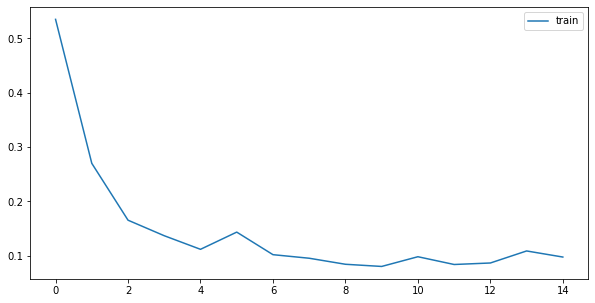

In [44]:
plot_training(train_metric='loss', val_metric='val_loss')

Confusion Matrix
[[70  1]
 [ 1 42]]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Normalized confusion matrix


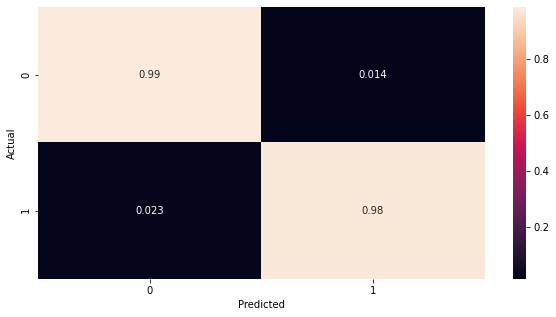

In [45]:
print_metrics(x_test, y_test)

<font color='red'>
<p>Comparando com o modelo treinado anteriormente, onde a a base não foi normalizada, é possível verificar que houve uma melhora na taxa de verdadeiro positivos, porém isso ocorreu ao custo da diminuição do número de verdadeiro negativos. Na prática o modelo classificaria pessoas com câncer benigno como malígno, o que demandaria maiores investigações por parte da equipe médica. Outro ponto positivo foi a diminuição do número de falso negativo (o que entendo ser positivo dados as características do problema). 
<p>Comparando com o modelo anterior, é possível observar um aumento na f1-score, além da obtenção de "loss" inferior e com menos epochs para atingir o resultado. 
</font>

## Parte III - Mudança de configurações do modelo

### 1)	Insira o conjunto de validação para o treinamento do modelo. Avalie o resultado obtido.

#### Rascunho

In [46]:
del model

In [47]:
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()

es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.2, callbacks =[es, mc], verbose=0)

#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 16        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 00019: early stopping
Train: 0.976, Test: 0.974


loss x epochs


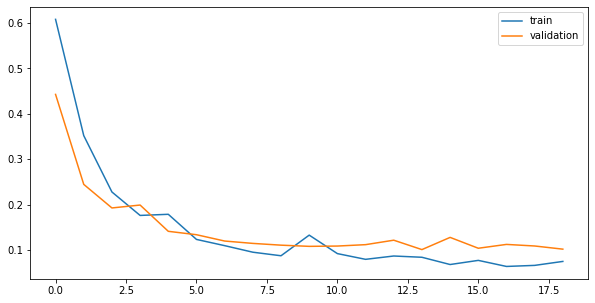

In [48]:
plot_training(train_metric='loss', val_metric='val_loss')

#### Resposta

Confusion Matrix
[[69  2]
 [ 1 42]]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Normalized confusion matrix


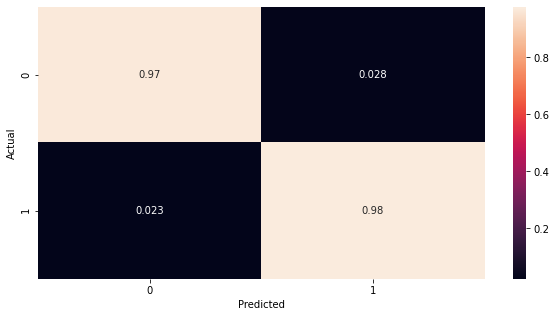

In [49]:
print_metrics(x_test, y_test)

<font color='red'>
<p> A inclusão do conjunto de validação, permite maior controle sobre o processo de treinamento, buscando melhorar o resultado do modelo quando analisado pela ótica do "modelo de negócio".
<p> Através do gráfico que representa o valor da loss do treinamento, é possível notar que a partir de deterinada época, o a loss do conjunto de validação parou de diminuir. Um dos cuidados que é possível tomar com o uso de um conjunto de validação, é evitar o overfitting. O overfitting pode ser evitado com a estratégia de Erlystopping. O overfitting pode ser verificado através do aumento da loss do conjunto de validação, acompanhado da diminuição da loss do conjunto de treinamento.
</font>

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha dois valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho

#### 2.1 Modelo utilizando 1 época:

In [50]:
del model

In [51]:
epochs=1

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()
# other arguments: min_delta=1
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.2, callbacks =[es, mc], verbose=0)
#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 16        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Train: 0.886, Test: 0.895


In [53]:
#plot_training(train_metric='loss', val_metric='val_loss')

Confusion Matrix
[[59 12]
 [ 0 43]]


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        71
           1       0.78      1.00      0.88        43

    accuracy                           0.89       114
   macro avg       0.89      0.92      0.89       114
weighted avg       0.92      0.89      0.90       114


Normalized confusion matrix


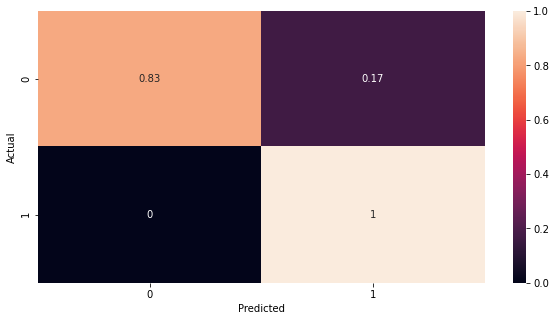

In [54]:
print_metrics(x_test, y_test)

#### 2.2 Modelo utilizando 100 épocas

In [55]:
del model

In [56]:
epochs=100

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()
# other arguments: min_delta=1

es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.20, callbacks =[es, mc], verbose=0)

#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 00019: early stopping
Train: 0.978, Test: 0.974


loss x epochs


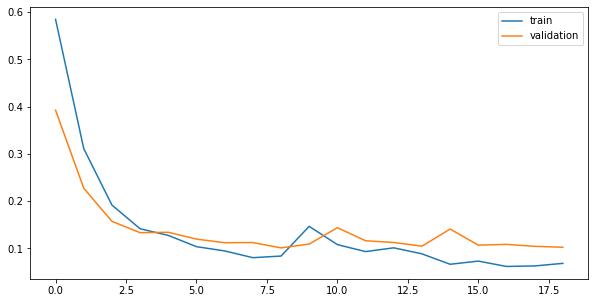

In [58]:
plot_training(train_metric='loss', val_metric='val_loss')

Confusion Matrix
[[69  2]
 [ 1 42]]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Normalized confusion matrix


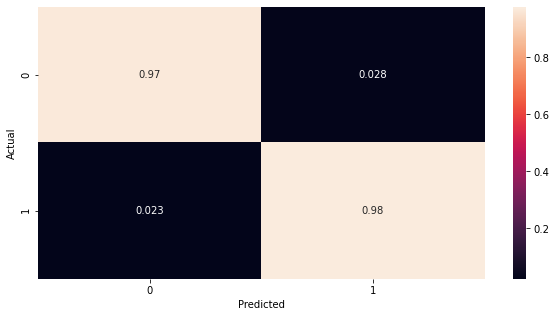

In [59]:
print_metrics(x_test, y_test)

<font color='red'>
<p>
Com o uso de poucas épocas, a tendência é que o modelo não consiga aprender para estabelecer a fronteira de decisão adequada para a complexidade do problema, pois ocorrem menos ciclos de aprendizado (ajustes de parâmetros). Com o aumento do número de épocas, a tendência é que o contrário aconteça, porém é importante tomar cuidados para que o modelo não realize overfitting dos dados.
</font>

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha dois valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho

#### 3.1 Modelo com taxa de aprendizado de 0,0001

In [60]:
del model

In [61]:
lr = 0.0001

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()
epochs=1000
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs,validation_split=0.2, verbose=0)
#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Train: 0.956, Test: 0.965


loss x epochs


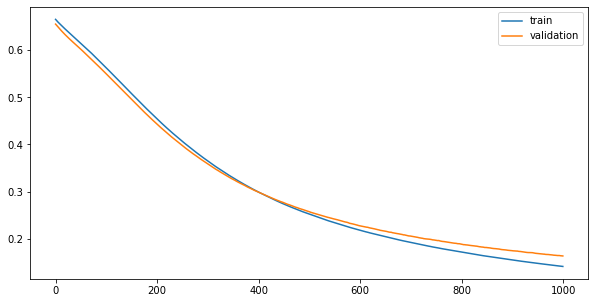

Confusion Matrix
[[69  2]
 [ 2 41]]


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114


Normalized confusion matrix


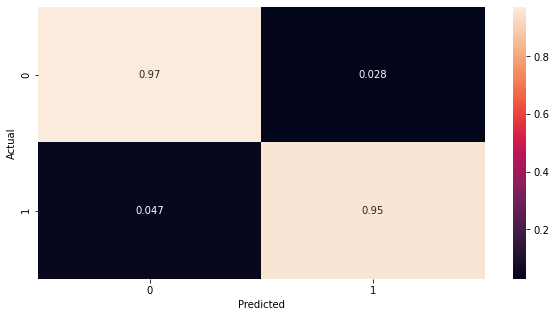

In [63]:
plot_training(train_metric='loss', val_metric='val_loss')
print_metrics(x_test, y_test)

#### 3.2 Modelo com taxa de aprendizado de 0,1

In [64]:
del model

In [65]:
lr = 0.1

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()
epochs=1000
# other arguments: min_delta=1
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.2, callbacks =[es, mc], verbose=0)
#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 16        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 00120: early stopping
Train: 0.927, Test: 0.895


loss x epochs


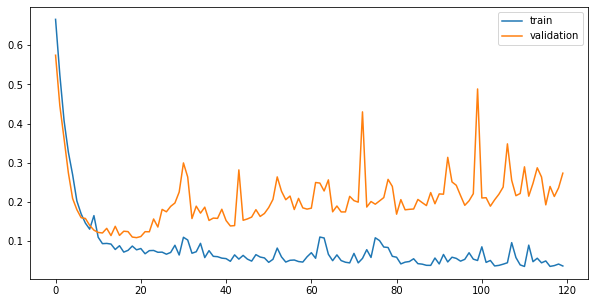

Confusion Matrix
[[59 12]
 [ 0 43]]


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        71
           1       0.78      1.00      0.88        43

    accuracy                           0.89       114
   macro avg       0.89      0.92      0.89       114
weighted avg       0.92      0.89      0.90       114


Normalized confusion matrix


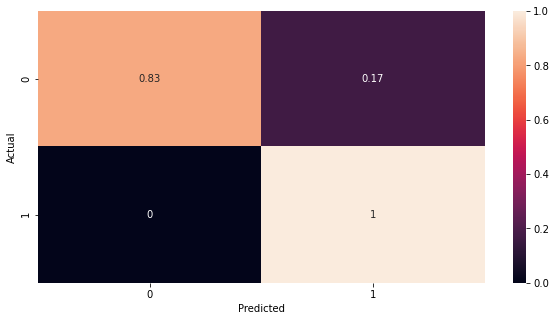

In [67]:
plot_training(train_metric='loss', val_metric='val_loss')
print_metrics(x_test, y_test)

#### Resposta

<font color='red'>
<p> A variação da taxa de aprendizado muda a constante que multiplica a derivada do erro (calculado na respectiva época ou batch). Uma taxa de aprendizado muito baixa pode levar o modelo a ficar preso em um ótimo local. Uma taxa muito alta já pode levar o modelo a não convergir, pois há o risco de a atualização dos pesos ser tão grande que o otimizador não consiga parar no ponto de mínimo (ficaria oscilando em torno deste ponto).    
<p> Para este problema, a menor taxa levou a um resultado melhor.
</font>

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha dois valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

In [68]:
del model

#### 4.1 Modelo com 2 neurônios na camada escondida:

In [69]:
lr = 0.05
hidden_neurons = [2]
activation_layers = ['relu']
output_activation = 'sigmoid'
epochs = 1000

In [70]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()
# other arguments: min_delta=1
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.2, callbacks =[es, mc], verbose=0)
#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 42        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
Epoch 00133: early stopping
Train: 0.978, Test: 0.974


loss x epochs


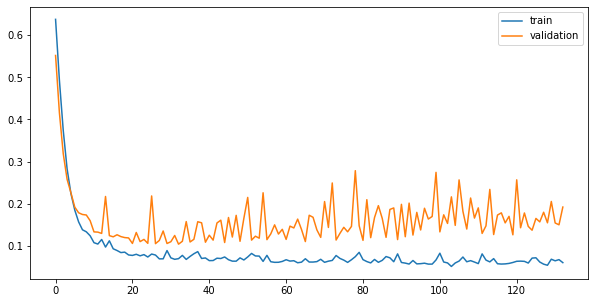

Confusion Matrix
[[69  2]
 [ 1 42]]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Normalized confusion matrix


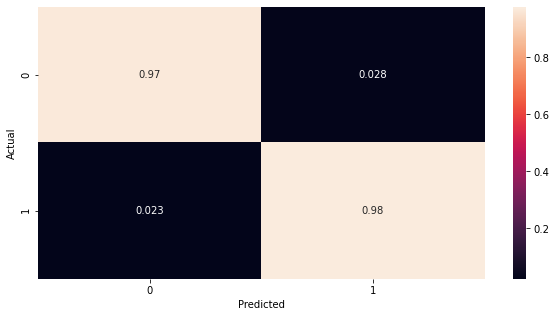

In [71]:
plot_training(train_metric='loss', val_metric='val_loss')
print_metrics(x_test, y_test)

#### 4.2 Modelo com 70 neurônios na camada escondida:

In [72]:
del model

In [73]:
hidden_neurons = [70]

In [74]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
model.summary()
# other arguments: min_delta=1
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# other arguments: min_delta=1
history = model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.2, callbacks =[es, mc], verbose=0)
#Evaluate the model
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 70)                1470      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 71        
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
_________________________________________________________________
Epoch 00110: early stopping
Train: 0.985, Test: 0.965


loss x epochs


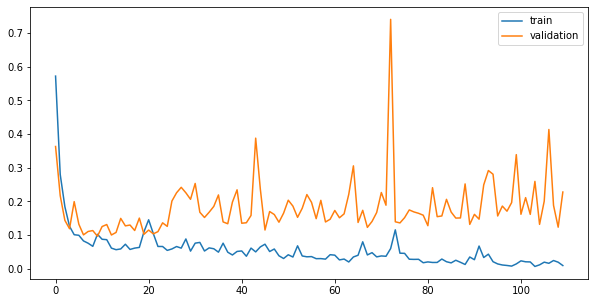

Confusion Matrix
[[69  2]
 [ 2 41]]


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114


Normalized confusion matrix


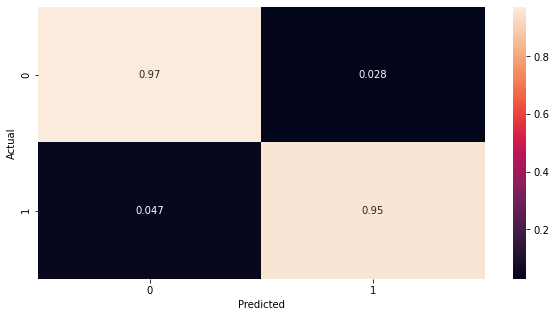

In [75]:
plot_training(train_metric='loss', val_metric='val_loss')
print_metrics(x_test, y_test)

#### Resposta

<font color='red'>
<p>Comparando os dois modelos, é possível notar que o modelo com mais neurônios tendeu a realizar overfitting dos dados, pois o mesmo é dotado de complexidade maior, conseguindo criar fronteiras de decisão que se ajustam mais fortemente aos dados de treinamento que o modelo mais simples. Isto resultou em uma piora das métricas de avalição do classificador, mesmo com a adoção da estratégia de EarlyStopping.
</font>

## Parte IV - Análise dos resultados

### 1)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado. Use a técnica K-Fold (com K = 10) para analisar o resultado obtido.

#### Rascunho

In [76]:
del model

In [77]:
# kfold = KFold(n_splits=10, shuffle=True)
# for train, test in kfold.split(X, Y):
#     model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)
#     model.summary()
#     epochs=1000
#     callback = EarlyStopping(monitor='loss', patience=5)
#     model.fit(x=x_train,y=y_train,epochs=epochs, validation_split=0.00)

In [78]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
training_data = x_train[5:7]
training_data

array([[0.35775474, 0.60297599, 0.5531281 , 0.42978958, 0.38402062,
        0.62777778, 0.43828981, 0.09360855, 0.14869165, 0.13237244,
        0.30152913, 0.11972222, 0.2064785 , 0.15039117, 0.15792601,
        0.63811662, 0.61162694, 0.56118211, 0.52296472, 0.51856225],
       [0.35160206, 0.33885695, 0.31542837, 0.45463468, 0.31911903,
        0.33030303, 0.46251053, 0.27868912, 0.31157178, 0.2056294 ,
        0.78219725, 0.25151515, 0.52491002, 0.46276805, 0.75885466,
        0.18926237, 0.21335778, 0.17731629, 0.13936527, 0.21612226]])

In [79]:
# for train_index, val_index in kf.split(np.zeros(len(y_train)),y_train):
#     print(train_index, val_index)

In [80]:
#np.zeros(5)

Running fold:  1
Epoch 00284: early stopping
loss x epochs


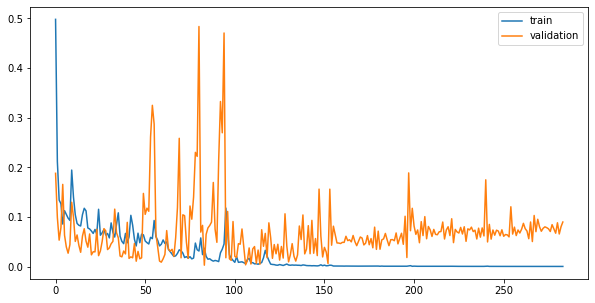

Running fold:  2
Epoch 00399: early stopping
loss x epochs


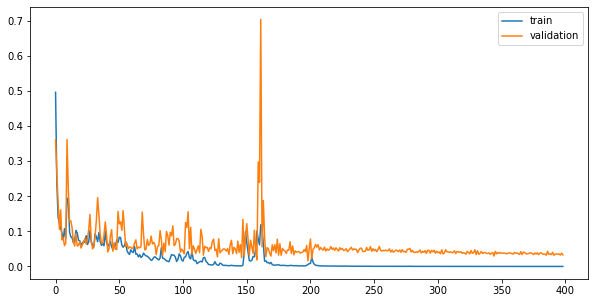

Running fold:  3
loss x epochs


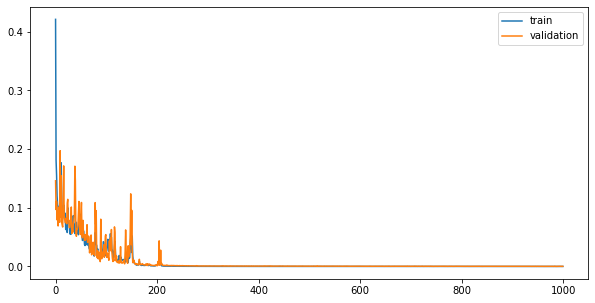

Running fold:  4
Epoch 00216: early stopping
loss x epochs


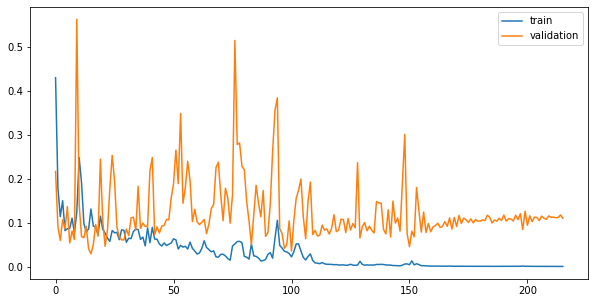

Running fold:  5
Epoch 00206: early stopping
loss x epochs


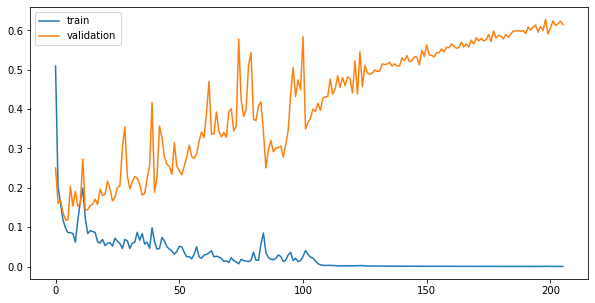

Running fold:  6
Epoch 00313: early stopping
loss x epochs


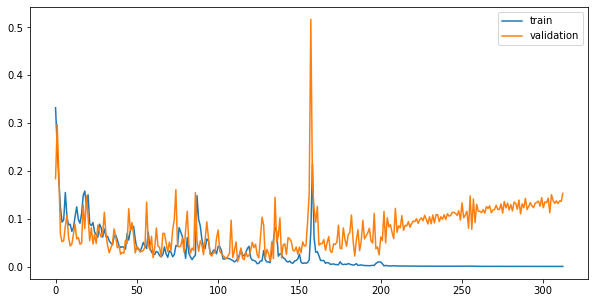

Running fold:  7
Epoch 00356: early stopping
loss x epochs


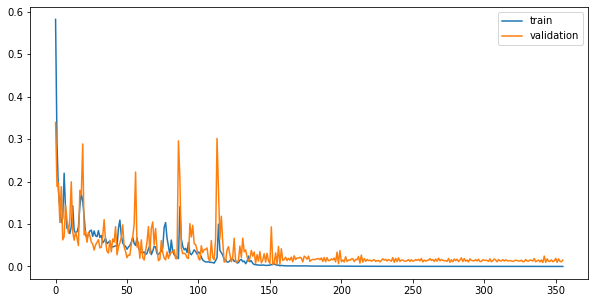

Running fold:  8
Epoch 00225: early stopping
loss x epochs


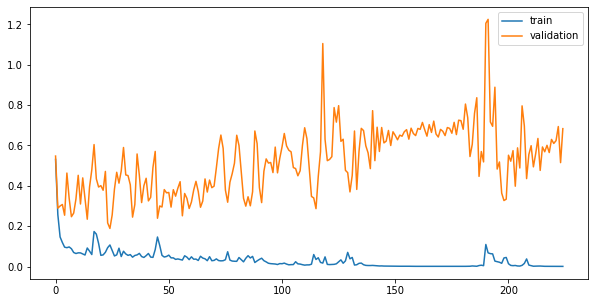

Running fold:  9
Epoch 00495: early stopping
loss x epochs


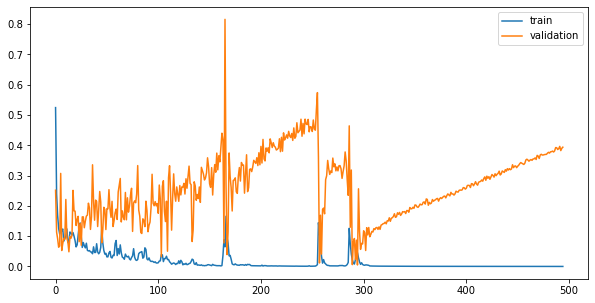

Running fold:  10
Epoch 00304: early stopping
loss x epochs


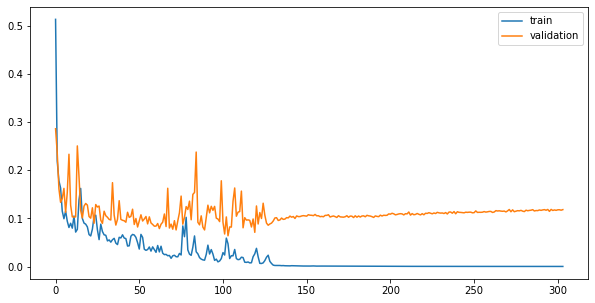

In [81]:
#del model
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

kf = KFold(n_splits = 10)
lr = 0.05
epochs=1000
hidden_neurons = [100]


VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

#save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(len(y_train)),y_train):
    print('Running fold: ',fold_var)
    x_train_split = x_train[train_index]
    y_train_split = y_train[train_index]
    x_val_split = x_train[val_index]
    y_val_split = y_train[val_index]
    
    # CREATE NEW MODEL
    model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)

    # CREATE CALLBACKS
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
#                                                     monitor='val_loss', verbose=0, 
#                                                     save_best_only=True, mode='min')
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
                                                    monitor='val_loss', verbose=0, 
                                                    save_best_only=True, mode='min')
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.2)
 
    callbacks_list = [checkpoint, es]
    #callbacks_list = []
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(x=x_train_split,
                        y=y_train_split,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        validation_data=(x_val_split,y_val_split),
                        verbose=0)
    
    #history = model.fit(x=x_train,y=y_train,epochs=epochs,validation_split=0.2, verbose=0)
    
    #PLOT HISTORY
    
    plot_training(train_metric='loss', val_metric='val_loss')
    
# LOAD BEST MODEL to evaluate the performance of the model
#   model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
    model.load_weights("model_"+str(fold_var)+".h5")

    results = model.evaluate(x_val_split,y_val_split, verbose=0)
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1

In [82]:
print(VALIDATION_ACCURACY)
print(VALIDATION_LOSS)

[1.0, 1.0, 1.0, 1.0, 0.9782609, 1.0, 1.0, 0.9111111, 1.0, 0.9777778]
[0.002684612115642623, 0.01608706089546499, 0.00011671403454665383, 0.029179864765509315, 0.11849870759507884, 0.010228540862186088, 0.005195274465303454, 0.18914095362027486, 0.005075420765206218, 0.06380739104416636]


In [83]:
min_value = min(VALIDATION_LOSS)
min_index = VALIDATION_LOSS.index(min_value)
min_index

2

Carregando o melhor modelo observado em todos os folds

In [84]:
model.load_weights("model_"+str(min_index+1)+".h5")
results = model.evaluate(x_test,y_test, verbose=0)
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1.000, Test: 0.947


Confusion Matrix
[[67  4]
 [ 2 41]]


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        71
           1       0.91      0.95      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114


Normalized confusion matrix


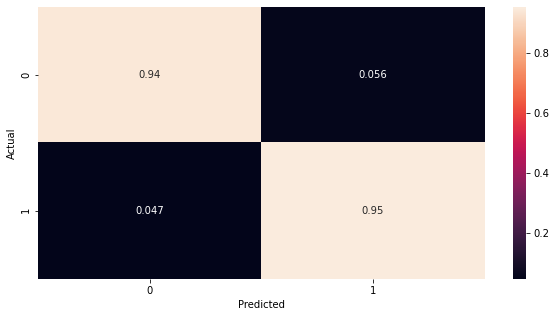

In [85]:
print_metrics(x_test, y_test)

#### Resposta

<font color='red'>
    <p> O uso da validação através de kfold permite observar o treinamendo do modelo com a utilização de todos os dados da respectiva base, pois não há separação de uma parte para uso no conjunto de validação. Analisando as curvas de loss, é possível observar uma indicação de que a taxa de aprendizado está alta (loss está variando bastante). Outra utilidade da estratégia k-fold é a possibilidade de avaliar a capacidade de generalização do modelo frente a várias configurações dos hiperparâmetros do mesmo. 
</font>

In [86]:
 type(VALIDATION_ACCURACY)

list

### 2)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

#### Rascunho

Running fold:  1
loss x epochs


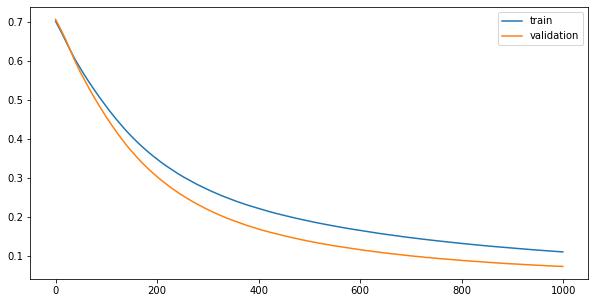

Running fold:  2
loss x epochs


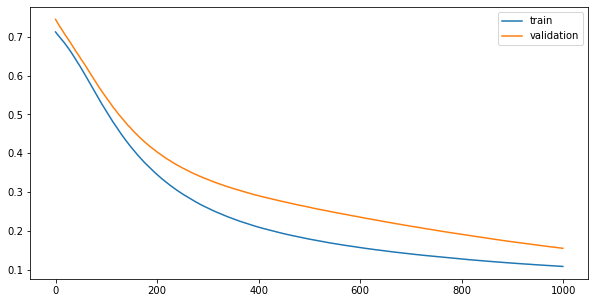

Running fold:  3
loss x epochs


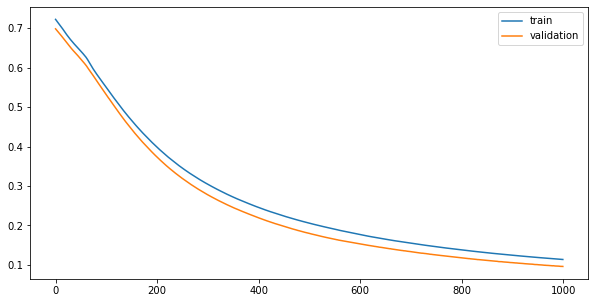

Running fold:  4
loss x epochs


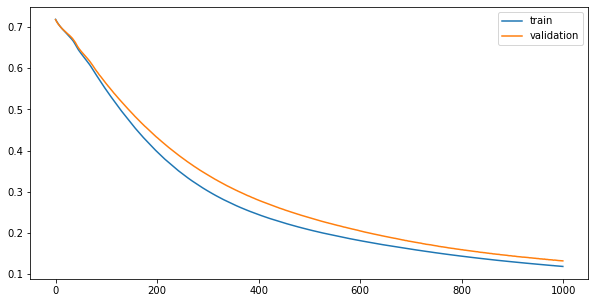

Running fold:  5
loss x epochs


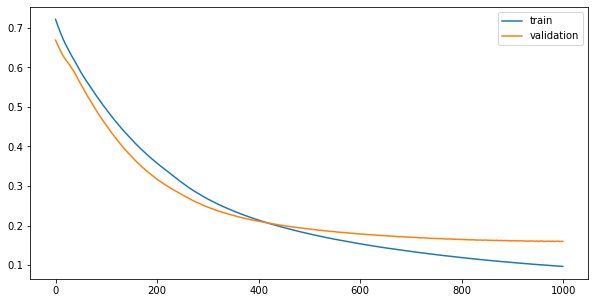

Running fold:  6
loss x epochs


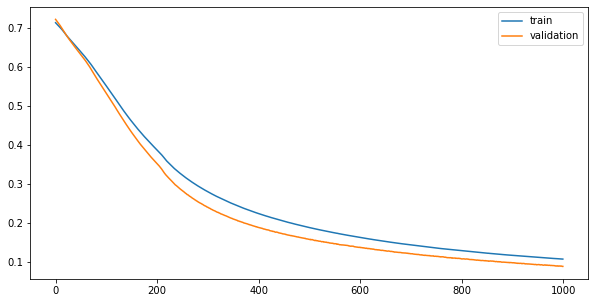

Running fold:  7
loss x epochs


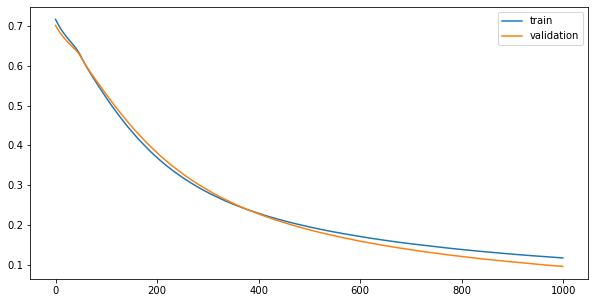

Running fold:  8
loss x epochs


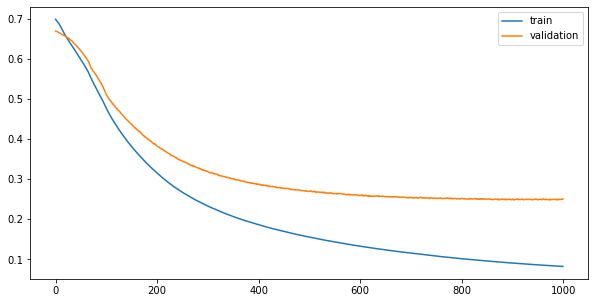

Running fold:  9
loss x epochs


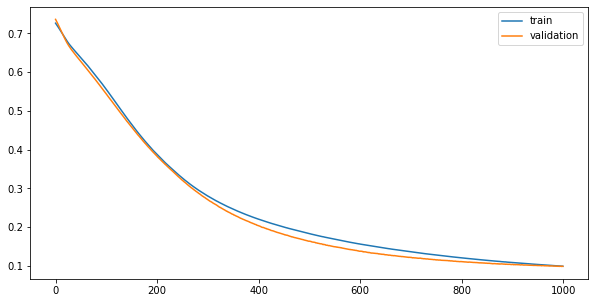

Running fold:  10
loss x epochs


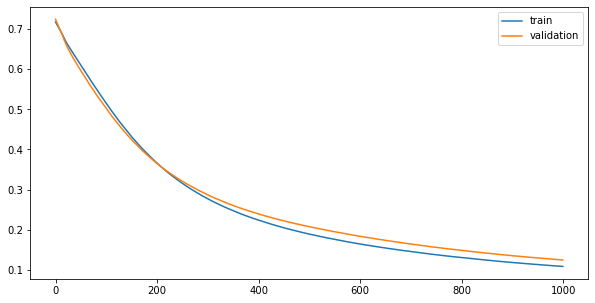

In [91]:
#del model

X = new_df.values[:,:-1].astype('float')
# Utilizando a base sem os features de alta correlação
#X = new_df.drop(to_drop, axis=1).values[:,:-1].astype('float')
target = new_df.values[:,-1]
encoder = LabelEncoder()
Y = encoder.fit_transform(target)
n_input = X.shape[1]
n_output = 1

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

kf = KFold(n_splits = 10)
lr = 0.0001
epochs=1000
hidden_neurons = [15]


VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

#save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(len(y_train)),y_train):
    print('Running fold: ',fold_var)
    x_train_split = x_train[train_index]
    y_train_split = y_train[train_index]
    x_val_split = x_train[val_index]
    y_val_split = y_train[val_index]
    
    # CREATE NEW MODEL
    model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)

    # CREATE CALLBACKS
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
#                                                     monitor='val_loss', verbose=0, 
#                                                     save_best_only=True, mode='min')
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
                                                    monitor='val_loss', verbose=0, 
                                                    save_best_only=True, mode='min')
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=epochs*0.2)
 
    callbacks_list = [checkpoint, es]
    #callbacks_list = []
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(x=x_train_split,
                        y=y_train_split,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        validation_data=(x_val_split,y_val_split),
                        verbose=0)
    
    #history = model.fit(x=x_train,y=y_train,epochs=epochs,validation_split=0.2, verbose=0)
    
    #PLOT HISTORY
    
    plot_training(train_metric='loss', val_metric='val_loss')
    
# LOAD BEST MODEL to evaluate the performance of the model
#   model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
    model.load_weights("model_"+str(fold_var)+".h5")

    results = model.evaluate(x_val_split,y_val_split, verbose=0)
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1

In [92]:
print(VALIDATION_ACCURACY)
print(VALIDATION_LOSS)
min_value = min(VALIDATION_LOSS)
min_index = VALIDATION_LOSS.index(min_value)
min_index

[0.9782609, 0.9347826, 0.9782609, 1.0, 0.9347826, 0.9777778, 0.9777778, 0.9111111, 0.9777778, 0.93333334]
[0.07189924820609715, 0.1550432058132213, 0.09579318891400876, 0.13243473418380902, 0.15996332806737526, 0.08938707576857673, 0.0951670045653979, 0.24790064228905573, 0.09850899891720878, 0.12465490715371239]


0

Carregando o melhor modelo de todos os folds.

In [93]:
model.load_weights("model_"+str(min_index+1)+".h5")
results = model.evaluate(x_test,y_test, verbose=0)
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.978, Test: 0.982


Confusion Matrix
[[70  1]
 [ 1 42]]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Normalized confusion matrix


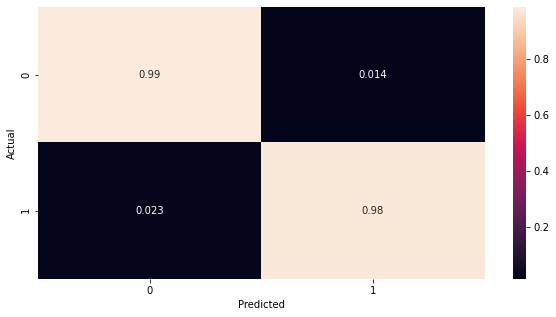

In [94]:
print_metrics(x_test, y_test)

#### Resposta

<font color='red'>
    <p> Neste implementação foi buscado juntar todas as observações anteriores para definição dos hiperparâmetros e estratégia de treinamento ideais.</p>
    <p>Foram utilizados os seguintes hiperparâmetros:
        <li>kf = KFold(n_splits = 10)</li>
        <li>lr = 0.0001</li>
        <li>epochs=1000</li>
        <li>hidden_neurons = [15]</li></p>
    <p>Com esta configuração, foi possível observar um dos melhores resultados de todos os modelos treinados neste trabalho. A grande vantagem do uso do kfold é a possibilidade de se observar a capacidade de generalização do modelo sem abrir mão da registros para o treinamento do modelo.</p>
</font>